    Team ID:16  Sem:V  Div:A  Dept:Computer Science
    Title ID:5DMACP03       
    Project Title:Riiid! Answer Correctness Prediction

    Problem Statement: Analyze the information a complete education app would have i.e. a student's historic performance, the performance of other students on the same question, metadata about the question, etc. and predict whether students are able to answer their next questions correctly. 

        Names              USN            Roll Number
        ATUL KUMAR         01FE18BCS056     156		
        ISHA BHANDARY	  01FE18BCS063     163
        DEEPIKA KULKARNI   01FE18BCS070     170
        ARPITA MATTIHAL	  01FE18BCS048     148



In [72]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
#Loading the csv files
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

train1 = pd.read_csv('DMA/train.csv',dtype=dtypes,nrows=10000)
train=train1.head(9500)
train2_fe=train1.sample(1000)
lectures = pd.read_csv('DMA/lectures.csv')
questions = pd.read_csv('DMA/questions.csv')
#test = pd.read_csv('Project/example_test.csv')
train.prior_question_elapsed_time.replace(np.nan,-1,inplace=True)
train.prior_question_had_explanation.replace(np.nan,'False',inplace=True)
train.prior_question_had_explanation.replace(np.nan,False,inplace=True)
#train.prior_question_had_explanation=(train['prior_question_had_explanation'] == 'TRUE').astype(np.int8)
train=train*1
train.prior_question_had_explanation.replace('False',0,inplace=True)
train.drop(columns=['row_id','timestamp','task_container_id','user_answer'],axis=1,inplace=True)

C:\Users\atulk\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


<h3>DATA CLEANING</h3>

In [73]:
#Filling the missing tag value with the 6 most frequent tags that appear with part 6
List=questions.query('part==6')
tag_n=List.tags.value_counts()[:6]
print(tag_n)
questions.tags.fillna('27 53 73 1 179 96',inplace=True)

27     261
53     106
73     105
1       65
179     46
96      43
Name: tags, dtype: int64


<b>Discretization for prior_question_elapsed_time

In [74]:
train.prior_question_elapsed_time.replace(np.nan,-1,inplace=True)
train['prior_question_elapsed_time']=pd.cut(train.prior_question_elapsed_time,bins=[-15000,0,15000,30000,50000,500000], labels=['-1','very quick','quick','moderate','slow'])
train.head()


,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,0,1,-1,0
1,115,5716,0,1,moderate,0
2,115,128,0,1,slow,0
3,115,7860,0,1,quick,0
4,115,7922,0,1,very quick,0


<b>Ordinal encoding for prior_question_elapsed_time

In [75]:
import category_encoders as ce

# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['prior_question_elapsed_time'],mapping=[{'col':'prior_question_elapsed_time',
'mapping':{'very quick':1,'quick':2,'moderate':3,'slow':4}}])


train= encoder.fit_transform(train)
train.head()



,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,0,1,-1.0,0
1,115,5716,0,1,3.0,0
2,115,128,0,1,4.0,0
3,115,7860,0,1,2.0,0
4,115,7922,0,1,1.0,0


In [76]:
train.tail()

,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
9495,91216,9560,0,1,2.0,1
9496,91216,6403,0,1,1.0,1
9497,91216,4453,0,0,2.0,1
9498,91216,746,0,1,1.0,1
9499,91216,1235,0,1,2.0,1


<b>Changing the datatype of tags in questions.csv to string and then splitting into 6 columns:tag1,tag2,tag3,tag4,tag5,tag6

In [77]:
questions.tags=questions.tags.astype(str)
questions[['Tag1', 'Tag2','Tag3','Tag4','Tag5','Tag6']] = questions['tags'].apply(lambda x: pd.Series(x.split(' ')))
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6
0,0,0,0,1,51 131 162 38,51,131,162,38,NaN,NaN
1,1,1,1,1,131 36 81,131,36,81,NaN,NaN,NaN
2,2,2,0,1,131 101 162 92,131,101,162,92,NaN,NaN
3,3,3,0,1,131 149 162 29,131,149,162,29,NaN,NaN
4,4,4,3,1,131 5 162 38,131,5,162,38,NaN,NaN


<b>Changing the datatype of prior_question_had_explanation from bool to int

<h3>Data Reduction</h3>

In [78]:
questions.drop(columns=['correct_answer','bundle_id','tags'],axis=1,inplace=True)
questions.head()

,question_id,part,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6
0,0,1,51,131,162,38,NaN,NaN
1,1,1,131,36,81,NaN,NaN,NaN
2,2,1,131,101,162,92,NaN,NaN
3,3,1,131,149,162,29,NaN,NaN
4,4,1,131,5,162,38,NaN,NaN


In [79]:
lectures.drop(columns=['type_of'],axis=1,inplace=True)
lectures.head()

,lecture_id,tag,part
0,89,159,5
1,100,70,1
2,185,45,6
3,192,79,5
4,317,156,5


In [80]:
train.columns

Index(['user_id', 'content_id', 'content_type_id', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')

<h3>Data Integration</h3>

In [81]:
#creating lecture_id and question_id in train to merge with lectures and questions
q_id=[]
l_id=[]
i=0
for typec in train.content_type_id:
    if(typec==0):
        q_id.append(train.content_id[i])
        l_id.append(np.nan)
    else:
        q_id.append(np.nan)
        l_id.append(train.content_id[i])
    i=i+1

In [82]:
train['lecture_id']=l_id
train['question_id']=q_id

In [83]:
#merge questions and lectures with train
tqmerge=pd.merge(train,questions,how='left', on='question_id')

In [84]:
tlmerge=pd.merge(tqmerge,lectures,how='left', on='lecture_id')

In [85]:
tlmerge.columns

Index(['user_id', 'content_id', 'content_type_id', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'lecture_id', 'question_id', 'part_x', 'Tag1', 'Tag2', 'Tag3', 'Tag4',
       'Tag5', 'Tag6', 'tag', 'part_y'],
      dtype='object')

In [86]:
tlmerge.part_x.replace(np.nan,' ',inplace=True)
tlmerge.part_y.replace(np.nan,' ',inplace=True)
tlmerge.Tag1.replace(np.nan,' ',inplace=True)
tlmerge.tag.replace(np.nan,' ',inplace=True)
tlmerge['part']= tlmerge["part_x"].astype(str) +" "+ tlmerge['part_y'].astype(str)
tlmerge['Tag1']= tlmerge["Tag1"].astype(str) +" "+ tlmerge['tag'].astype(str)

In [87]:
#drop the redundant columns
tlmerge.drop(columns=['tag','part_x','part_y','lecture_id','question_id'],axis=1, inplace=True)
tlmerge.head()

,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,part
0,115,5692,0,1,-1.0,0,151,NaN,NaN,NaN,NaN,NaN,5.0
1,115,5716,0,1,3.0,0,168,NaN,NaN,NaN,NaN,NaN,5.0
2,115,128,0,1,4.0,0,131,149,92,NaN,NaN,NaN,1.0
3,115,7860,0,1,2.0,0,131,104,81,NaN,NaN,NaN,1.0
4,115,7922,0,1,1.0,0,131,149,92,NaN,NaN,NaN,1.0


In [88]:
tlmerge.Tag1.replace(np.nan,-1,inplace=True)
tlmerge.Tag2.replace(np.nan,-1,inplace=True)
tlmerge.Tag3.replace(np.nan,-1,inplace=True)
tlmerge.Tag4.replace(np.nan,-1,inplace=True)
tlmerge.Tag5.replace(np.nan,-1,inplace=True)
tlmerge.Tag6.replace(np.nan,-1,inplace=True)

In [89]:
tlmerge.head()

,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,part
0,115,5692,0,1,-1.0,0,151,-1,-1,-1,-1,-1,5.0
1,115,5716,0,1,3.0,0,168,-1,-1,-1,-1,-1,5.0
2,115,128,0,1,4.0,0,131,149,92,-1,-1,-1,1.0
3,115,7860,0,1,2.0,0,131,104,81,-1,-1,-1,1.0
4,115,7922,0,1,1.0,0,131,149,92,-1,-1,-1,1.0


In [90]:
tlmerge.Tag1=tlmerge.Tag1.astype(np.float16)
tlmerge.Tag2=tlmerge.Tag2.astype(np.float16)
tlmerge.Tag3=tlmerge.Tag3.astype(np.float16)
tlmerge.Tag4=tlmerge.Tag4.astype(np.float16)
tlmerge.Tag5=tlmerge.Tag5.astype(np.float16)
tlmerge.Tag6=tlmerge.Tag6.astype(np.float16)
tlmerge.part=tlmerge.part.astype(np.float16)
tlmerge.head()

,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,part
0,115,5692,0,1,-1.0,0,151.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0
1,115,5716,0,1,3.0,0,168.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0
2,115,128,0,1,4.0,0,131.0,149.0,92.0,-1.0,-1.0,-1.0,1.0
3,115,7860,0,1,2.0,0,131.0,104.0,81.0,-1.0,-1.0,-1.0,1.0
4,115,7922,0,1,1.0,0,131.0,149.0,92.0,-1.0,-1.0,-1.0,1.0


In [91]:
#X.head()

In [92]:
#del List,test,lectures

In [93]:
%who_ls DataFrame

['K',
 'List',
 'X',
 'features_test',
 'features_train',
 'lectures',
 'questions',
 'tl2merge',
 'tlmerge',
 'tq2merge',
 'tqmerge',
 'train',
 'train1',
 'train2_fe',
 'train2_fee']

In [94]:
# import lightgbm as lgb
# d_train = lgb.Dataset(features_train, label=labels_train)

# params = {}
# params['learning_rate'] = 0.2
# params['objective'] = 'binary'
# params['metric'] = 'auc_mc'
# params['num_leaves'] = 50
# params['max_depth'] = 100
# params['force_col_wise']=True
# clf = lgb.train(params, d_train, 100)

In [95]:
# pip install lightgbm

In [96]:
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
# from sklearn import decomposition
# from sklearn.model_selection import GridSearchCV

# # Grid Search - Used to find best combination of parameters
# XGB_model = xgb.XGBClassifier(objective='binary:logistic')
# # 
# param_grid = {'max_depth': [100], 'learning_rate': [0.1], 
#               'n_estimators': [100]}
# #param_grid = {'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.3], 'n_estimators': [25, 50]} ##Note running this step can take a significant amount of time, might take hours as well.
# model = GridSearchCV(estimator=XGB_model, param_grid=param_grid,
#                                  scoring='roc_auc', verbose=1, n_jobs=1, 
#                                  iid=True, refit=True, cv=3)

# #model.fit(X, y)
# model.fit(features_train, labels_train)
# print("Best score: %0.3f" % model.best_score_)
# print("Best parameters set:")
# best_parameters = model.best_estimator_.get_params()
# for param_name in sorted(param_grid.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [97]:
X=tlmerge.drop('answered_correctly', axis=1, inplace=False)
X=X[X.content_type_id==0]
K=X
y=tlmerge[tlmerge.content_type_id==0]['answered_correctly']
print(X.shape)
print(y.shape)
from sklearn.model_selection import train_test_split
## Spliting of training dataset into 70% training data and 30% testing data randomly
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size=0.05, random_state=42)

(9283, 12)
(9283,)


In [98]:
%%time
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV

# Grid Search - Used to find best combination of parameters
model = xgb.XGBClassifier(booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=9,
              min_child_weight=1,monotone_constraints='()',
              n_estimators=210, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=500, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              validate_parameters=1, verbosity=0,min_samples_split=2,eval_metric='auc')

#model.fit(X, y)
model.fit(features_train, labels_train)
prediction = model.predict_proba(features_test)[:,1]
from sklearn.metrics import roc_auc_score
print(roc_auc_score(labels_test,prediction))

0.5733838383838383
Wall time: 1.65 s


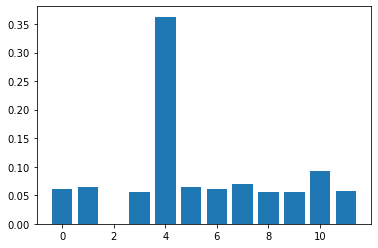

[0.06044553 0.06401528 0.         0.05486645 0.36273098 0.06509499
 0.06033839 0.07019731 0.0564777  0.05546911 0.09288628 0.057478  ]


In [99]:
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(importance)

In [100]:
train2_fe.reset_index(inplace=True)
train2_fe.prior_question_elapsed_time.replace(np.nan,-1,inplace=True)
train2_fe.prior_question_had_explanation.replace(np.nan,False,inplace=True)
train2_fe.prior_question_had_explanation=(train2_fe['prior_question_had_explanation'] == True).astype(np.int8)
#train['prior_question_elapsed_time']=pd.cut(train.prior_question_elapsed_time,bins=[-5,0,15000,30000,50000,300000], labels=['No','Quick','NOrmal','Slow','VerySlow'])
train2_fe['prior_question_elapsed_time']=pd.cut(train2_fe.prior_question_elapsed_time,bins=[-5,0,15000,30000,50000,300000], labels=[-1,1,2,3,4])

train2_fe.prior_question_elapsed_time=(train2_fe.prior_question_elapsed_time).astype(np.int32)


#creating lecture_id and question_id in train to merge with lectures and questions
q2_id=[]
l2_id=[]
i=0
for typec in train2_fe.content_type_id:
    if(typec==0):
        q2_id.append(train2_fe.content_id[i])
        l2_id.append(np.nan)
    else:
        q2_id.append(np.nan)
        l2_id.append(train2_fe.content_id[i])
    i=i+1

train2_fe['lecture_id']=l2_id
train2_fe['question_id']=q2_id
train2_fe.drop(columns=['timestamp'],axis=1,inplace=True)
train2_fe.drop(columns=['user_answer'],axis=1,inplace=True)
train2_fe.drop(columns=['row_id'],axis=1,inplace=True)

train2_fe.drop(columns=['task_container_id',],axis=1,inplace=True)
#merge questions and lectures with train
tq2merge=pd.merge(train2_fe,questions,how='left', on='question_id')
tl2merge=pd.merge(tq2merge,lectures,how='left', on='lecture_id')
tl2merge.part_x.replace(np.nan,' ',inplace=True)
tl2merge.part_y.replace(np.nan,' ',inplace=True)
tl2merge.Tag1.replace(np.nan,' ',inplace=True)
tl2merge.tag.replace(np.nan,' ',inplace=True)
tl2merge['part']= tl2merge["part_x"].astype(str) +" "+ tl2merge['part_y'].astype(str)
tl2merge['Tag1']= tl2merge["Tag1"].astype(str) +" "+ tl2merge['tag'].astype(str)
tl2merge.drop(columns=['tag','part_x','part_y','lecture_id','question_id'],axis=1, inplace=True)
tl2merge.Tag1.replace(np.nan,-1,inplace=True)
tl2merge.Tag2.replace(np.nan,-1,inplace=True)
tl2merge.Tag3.replace(np.nan,-1,inplace=True)
tl2merge.Tag4.replace(np.nan,-1,inplace=True)
tl2merge.Tag5.replace(np.nan,-1,inplace=True)
tl2merge.Tag6.replace(np.nan,-1,inplace=True)
tl2merge.Tag1=tl2merge.Tag1.astype(np.float16)
tl2merge.Tag2=tl2merge.Tag2.astype(np.float16)
tl2merge.Tag3=tl2merge.Tag3.astype(np.float16)
tl2merge.Tag4=tl2merge.Tag4.astype(np.float16)
tl2merge.Tag5=tl2merge.Tag5.astype(np.float16)
tl2merge.Tag6=tl2merge.Tag6.astype(np.float16)
tl2merge.part=tl2merge.part.astype(np.float16)


In [101]:
tl2merge=tl2merge[tl2merge.content_type_id==0]
train2_fee=tl2merge.drop('answered_correctly',axis=1,inplace=False)
labels2_test=tl2merge.answered_correctly
train2_fee.drop('index',axis=1,inplace=True)

In [102]:

prediction = model.predict_proba(train2_fee)[:,1]

In [103]:

from sklearn.metrics import roc_auc_score
print(roc_auc_score(labels2_test,prediction))

0.8331778093611074


In [104]:
# from sklearn import tree
# clf = tree.DecisionTreeClassifier(min_samples_split=4,criterion='gini')
# clf.fit(features_train, labels_train)
# prediction = clf.predict(features_test)

# #print (prediction)
# from sklearn.metrics import accuracy_score
# print (accuracy_score(prediction,labels2_test))
# c
# from sklearn.metrics import classification_report
# y_true = labels_test
# y_pred = prediction

# print(classification_report(y_true, y_pred))

In [106]:
features_train.columns


Index(['user_id', 'content_id', 'content_type_id',
       'prior_question_elapsed_time', 'prior_question_had_explanation', 'Tag1',
       'Tag2', 'Tag3', 'Tag4', 'Tag5', 'Tag6', 'part'],
      dtype='object')

In [105]:
# X.head()

# pip install pycaret --user

# from pycaret.classification import *
# exp = setup(data = tlmerge, target = 'answered_correctly') 

# compare_models(sort = 'AUC',fold=2,exclude=['svm']) 

# tlmerge=tlmerge[train.content_type_id==0]

# print(tlmerge.shape)

# tlmerge.head()

# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=[10**6,10**5, 10**4], cv=5)

# train_sizes, train_scores, valid_scores